In [1]:
# For HW2 each problem is done using a separate notebook, the .py file combined them together
# Problem 2

In [2]:
# Import Libs
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt

from scipy.stats import poisson
from sklearn.model_selection import KFold

In [3]:
# Read Data and Initialize K-Fold Splitter Object
cwd = os.getcwd()

# Read Data
X = pd.read_csv(cwd + "\X.csv", header = None).values
y = pd.read_csv(cwd + "\y.csv", header = None).values

# Declare the object for K-fold cross-validation
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [4]:
# Init Global variables
lambda_0 = []
lambda_1 = []
Matrix = [[0,0],[0,0]]

# 10-fold cross validation
for train_index,test_index in kf.split(X):
    
    # Do K-fold Partition of Data into Train and Test sets
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    # Calculate π, note that P(Y=y_i) = Bern(π) = {1 - π for y_i=0, π for y_i=1}
    # Here we write π_0, π_1 instead of π-1,π for better readability, note that π in Problem 1 equals to π_1
    pi_1 = (sum(y_train) / len(X_train))[0] 
    pi_0 = 1 - pi_1
    
    # Initialize λ_1, λ_0
    lambda_0d = []
    lambda_1d = []
    
    # Initialize N and D
    D = len(X_train[0])
    N = len(X_train)
    
    # Calculate λ_(1,d), λ_(0,d) for all d, based on formula described in Problem 1
    for d in range(D):
        
        # λ involves doing sum on both numerator and denominator
        # Add + 1 term on initialization
        lambda_0_numerator = 1
        lambda_0_denominator = 1
        
        lambda_1_numerator = 1
        lambda_1_denominator = 1
        
        # Sum over i to N
        for i in range(N):
            
            # Σ(1-y)*x_(i,d)
            lambda_0_numerator = lambda_0_numerator + ((1-y_train[i]) * X_train[i][d])
            # Σ(1-y)
            lambda_0_denominator = lambda_0_denominator + (1-y_train[i])
            
            # Σy*x_(i,d)
            lambda_1_numerator = lambda_1_numerator + (y_train[i] * X_train[i][d])
            # Σy
            lambda_1_denominator = lambda_1_denominator + (y_train[i])
            
        #EndFor
        
        # Construct vectors λ_1, λ_0, based on λ_(1,d), λ_(0,d)
        lambda_0d.append((lambda_0_numerator / lambda_0_denominator)[0])
        lambda_1d.append((lambda_1_numerator / lambda_1_denominator)[0])
        
    #Endfor
    
    # Store λ_1, λ_0 for Q2.2
    lambda_0.append(lambda_0d)
    lambda_1.append(lambda_1d)
    
    # Initialize Predicted y and N for test data
    N_test = len(X_test)
    D_test = len(X_test[0])
    y_predicted = []
    
    # Calculate Predicted y
    for i in range(N_test):
        
        # P(Y=y|X=x) = P(Y=y) * P(X=x|Y=y) = Bern(π) * Poisson(λ) as in Problem 1
        # Init Temp variable to store Poisson(λ_d)
        P_y0 = 1
        P_y1 = 1
        
        # Collect Poisson Terms over d
        for d in range(D_test):
            
            poisson_0 = poisson.pmf(X_test[i][d],lambda_0d[d])
            poisson_1 = poisson.pmf(X_test[i][d],lambda_1d[d])
            
            P_y0 *= (poisson_0)
            P_y1 *= (poisson_1)
        
        #Endfor
        
        # Apply Bern(π)
        P_y0 *= pi_0
        P_y1 *= pi_1
        
        # f(x) = argmax P(Y=y|X=x)
        if(P_y0 >= P_y1):
            y_predicted.append(0)
        else:
            y_predicted.append(1)
    
    #Endfor
    
    # Loop through all test and prediced y to construct matrix
    # P short for Predicted Value, T short for truevalue, T0P0 means predicted y is 0 while the true value is also 0
    # y_prediction[i] == 0
    T0P0 = 0
    T0P1 = 0
    T1P0 = 0
    T1P1 = 0
    
    for i in range(len(y_test)):
        if(y_test[i] == 0):
            if(y_predicted[i] == 0):
                T0P0 += 1
            else:
                T0P1 += 1
        else:
            if(y_predicted[i] == 0):
                T1P0 += 1
            else:
                T1P1 += 1
    
    #Endfor
    
    Matrix[0][0] += T0P0
    Matrix[0][1] += T0P1
    Matrix[1][0] += T1P0
    Matrix[1][1] += T1P1
    
#Endfor

In [5]:
print(Matrix[0])
print(Matrix[1], " Accuracy is: ", (Matrix[0][0] + Matrix[1][1])/4600)

[2296, 491]
[108, 1705]  Accuracy is:  0.8697826086956522


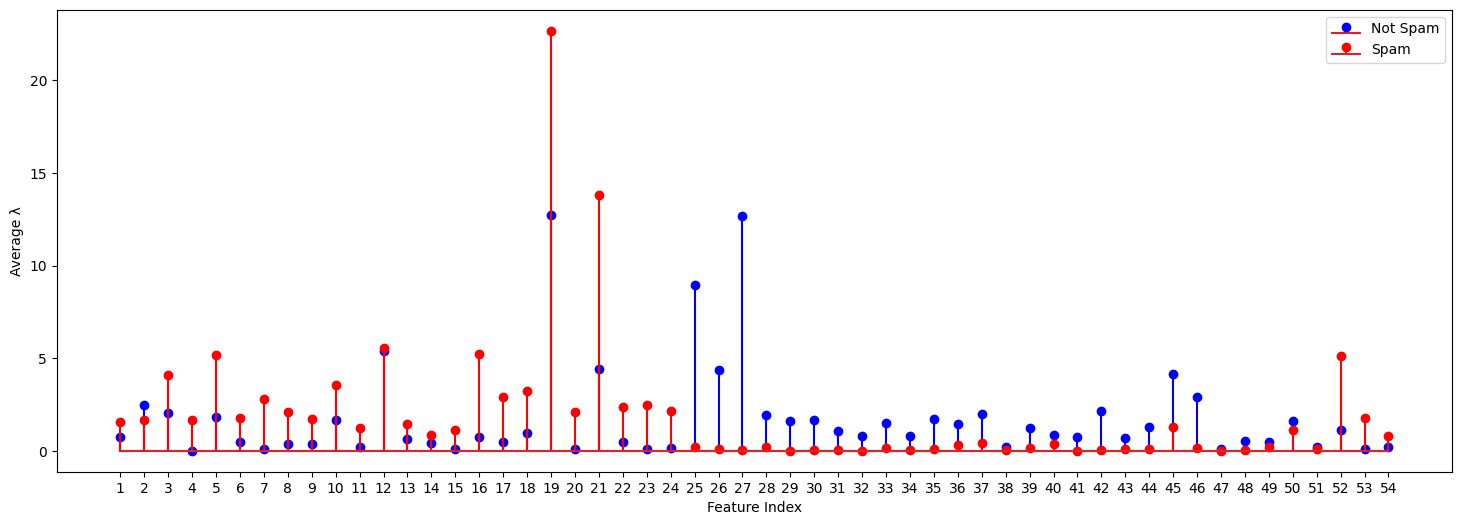

In [6]:
# Problem 2.2
# Calulate λ mean from previous question
average_lambda_0 = np.mean(lambda_0, axis = 0)
average_lambda_1 = np.mean(lambda_1, axis = 0)

plt.figure(figsize=(18,6))
plt.stem(range(1,55), average_lambda_0, "blue", markerfmt="bo", label="Not Spam")
plt.stem(range(1,55), average_lambda_1, "red", markerfmt="ro", label="Spam")
plt.xlabel("Feature Index")
plt.ylabel("Average λ")
plt.xticks(np.arange(1,55, step = 1))
plt.legend()
plt.show()

In [7]:
# Problem 2.3
# Global var
goodPredictionCount_list = []
badPredictionCount_list = []

# 10-fold cross validation
for train_index,test_index in kf.split(X):
    
    # Do K-fold Partition of Data into Train and Test sets
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    # Init Prediction accuarcy statistics
    goodPredictionCount = np.zeros(shape = (20))
    badPredictionCount = np.zeros(shape = (20))
    predictionAccuracy = np.zeros(shape = (20))
    
    # Standardization
    mean = np.mean(X_train,axis=0)
    std = np.std(X_train,axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std
    
    for rowNum in range(len(X_test)):
        
        # Init distance list for every new X_test
        distance_list = []
        
        # Caculate L1 distance for all
        for j in X_train:
            distance_list.append(np.linalg.norm(X_test[rowNum] - j, ord=1))
        
        # Extract 20th Nearest Neighbor
        KNN_list = np.argsort(distance_list)[:20]
        
        # Find k-th nearest neighbor
        for k in range(1,21):
            
            # Count nearest neighbour classifier
            count_y1 = np.sum(y_train[KNN_list[:k]])
            count_y0 = k-count_y1
            
            # Decide result of KNN
            # Break tie can be done arbitrarily, here we use y for the 1st nearest neighbour if there is tie.
            if(count_y1 == count_y0):
                
                # 1st nearest neighbour
                prediction_temp = y_train[KNN_list[0]][0]
                
                # Update Accuracy Statistics
                if(prediction_temp == y_test[rowNum][0]):
                    goodPredictionCount[k-1] += 1
                else:
                    badPredictionCount[k-1] += 1
            
            elif(count_y1 > count_y0):
                
                prediction_temp = 1
                
                # Update Accuracy Statistics
                if(prediction_temp == y_test[rowNum][0]):
                    goodPredictionCount[k-1] += 1
                else:
                    badPredictionCount[k-1] += 1
            
            else: #if(count_y1 < count_y0):
                
                prediction_temp = 0
                
                # Update Accuracy Statistics
                if(prediction_temp == y_test[rowNum][0]):
                    goodPredictionCount[k-1] += 1
                else:
                    badPredictionCount[k-1] += 1
            
        #Endfor
    
    #Endfor
    
    goodPredictionCount_list.append(goodPredictionCount.tolist())
    badPredictionCount_list.append(badPredictionCount.tolist())
    
#Endfor
    

In [8]:
# Post Processing
average_Good_Prediction = []
average_Bad_Prediction = []
average_Accuracy = []

for j in range(1,21):
    average_Good_Prediction.append(sum([i[j-1] for i in goodPredictionCount_list]))
    average_Bad_Prediction.append(sum([i[j-1] for i in badPredictionCount_list]))
    average_Accuracy.append(average_Good_Prediction[j-1] / (average_Good_Prediction[j-1] + average_Bad_Prediction[j-1]))
    

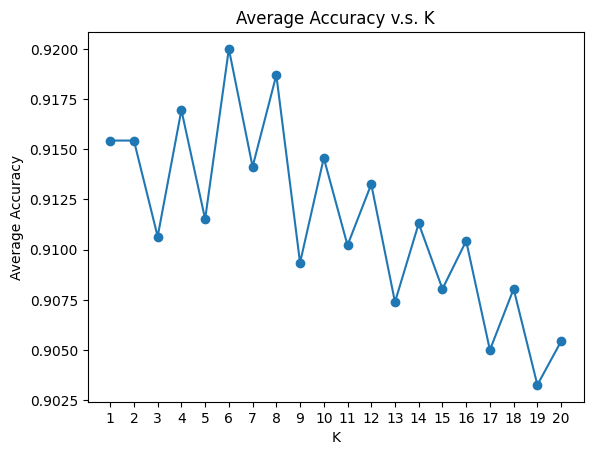

In [9]:
# Plot
plt.figure()
plt.plot(range(1,21),average_Accuracy)
plt.scatter(range(1,21),average_Accuracy)
plt.title("Average Accuracy v.s. K")
plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(np.arange(1,21, step = 1))
plt.show()